In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

# Initialize GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading the datasets

Applying data transformation and augmentation and Normalization on our images. We resize our 250x250 data to 224x224 as VGG16 is trained on 224x224 size image, then we flip at horizontal axis and finally conver tje image to torch.tensor so that it can work with torch

In [3]:
DATA_DIR = '../input/nepalicurrencynpr/Nepali Currency'

In [14]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                     transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                     ])

transform_valid = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                     ])

training_dataset = datasets.ImageFolder(DATA_DIR+'/Train', transform = transform_train)
validation_dataset = datasets.ImageFolder(DATA_DIR+'/Test',transform = transform_valid)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [15]:
print(len(training_dataset))
print(len(validation_dataset))

403
73


Converting the images in order to plot them using plt

In [16]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0,1)
    
    return image


In [17]:
classes = os.listdir(DATA_DIR+'/Train')
print(classes)

['Rs. 10', 'Rs.5', 'Rs. 500', 'Rs. 100', 'Rs. 20']


iterating our data to plot our images

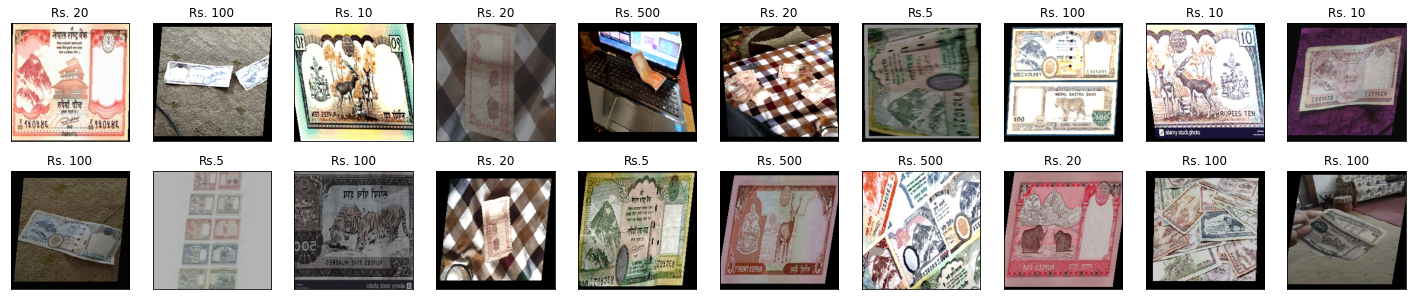

In [18]:
dataiter = iter(training_loader) #Converting our train folder to iterable so that it can be iterater through a batch of 20
images, labels = dataiter.next() #we get inputs for our model here
fig = plt.figure(figsize=(25,5))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

# Defining the VGG16 model

We are using VGG16 which has 16 layers

In [19]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [20]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
#Freezing feature parameters and using sane as in VGG16. 
for param in model.features.parameters():
    param.requires_grad = False #feature layer does not require any gradient

We take the last fully connect layer from vgg16 and replace it with our layer as we need to classify only 5 different categories

In [22]:
import torch.nn as nn

In [23]:
n_inputs = model.classifier[6].in_features #tge i/p features of our classifier model
last_layer = nn.Linear(n_inputs, len(classes)) #new layer that we want to put in there
model.classifier[6] = last_layer #replacing last layer of vgg16 with our new layer
model.to(device) #put the model in device for higher procesing power
print(model.classifier[6].out_features)

5


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
#learning rate is very small as we have small number of datasets

#Fitting the model with our inputs and displaying the progress

In [34]:
epochs = 5 #Less because of small number of datasets
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        #taking inputs and putting it in our model which is inside the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    
    else:
        with torch.no_grad():
            for val_inputs, val_labels  in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss = val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
            epoch_loss = running_loss/len(training_loader.dataset)
            epoch_acc = running_corrects.float()/len(training_loader.dataset) #we are now dividing the total loss of one epoch with the entire length of dataset to get the probability between 1 and 0
            running_loss_history.append(epoch_loss)
            running_corrects_history.append(epoch_acc)
            val_epoch_loss = val_running_loss/len(validation_loader.dataset)
            val_epoch_acc = val_running_corrects.float()/len(validation_loader)
            val_running_loss_history.append(val_epoch_loss)
            val_running_corrects_history.append(val_epoch_acc)
            print('epoch :', (e+1))
            print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item())) 
            print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item())) 
            
            
            
        
           

epoch : 1
training loss: 0.0073, acc 0.8784 
validation loss: 0.0001, validation acc 34.5000
epoch : 2
training loss: 0.0070, acc 0.8933 
validation loss: 0.0000, validation acc 35.0000
epoch : 3
training loss: 0.0042, acc 0.9132 
validation loss: 0.0000, validation acc 35.5000
epoch : 4
training loss: 0.0044, acc 0.9280 
validation loss: 0.0001, validation acc 36.0000
epoch : 5
training loss: 0.0038, acc 0.9429 
validation loss: 0.0028, validation acc 35.0000


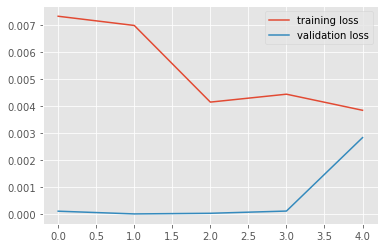

In [35]:
plt.style.use("ggplot")
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

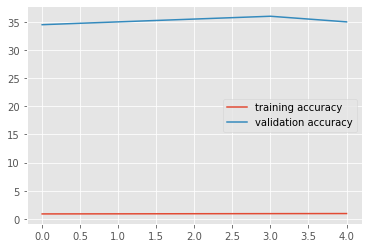

In [36]:
plt.style.use("ggplot")
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()


In [37]:
import PIL.ImageOps  # # from python imaging library we take this so we can preform operations on our image

In [38]:
import requests
from PIL import Image

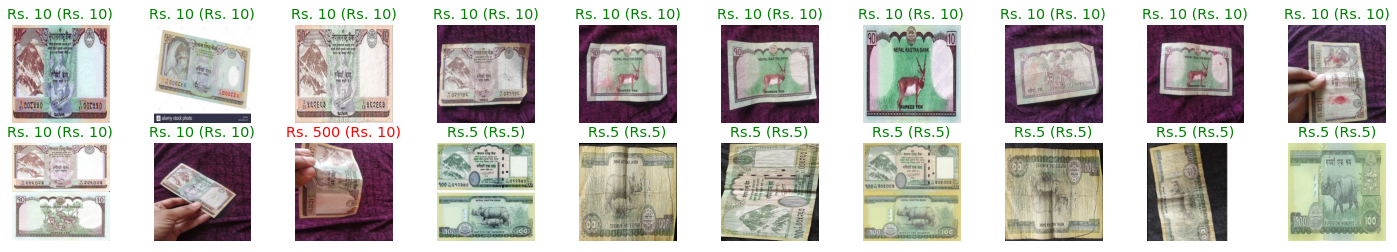

In [39]:

dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

In [44]:
torch.save(model.state_dict(), 'project-vgg16.pth')

In [45]:
project_name = 'Major Project'

In [46]:
!pip install jovian --upgrade --quiet

In [47]:
import jovian

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['project-vgg16.pth'])